# Main of the paper - LSR -  $\sigma=0$

In this notebook are gathered all experiments generated for the main of the paper using a least-squares regression which require absence of noise (i.e $\sigma=0$).

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, RMSEModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent, SGD_Descent
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.data.RealDatasetPreparation import prepare_quantum
from src.utils.Constants import *
from src.utils.data.DataClustering import *
from src.utils.data.DataPreparation import build_data_linear, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "without_noise"

nb_devices_for_the_run = 20
dim_notebook = 20

In [2]:
# Building data
w_true = generate_param(dim_notebook)
X, Y = build_data_linear(w_true, n_dimensions = dim_notebook, 
                         n_devices=nb_devices_for_the_run, with_seed=False, without_noise=True)
X = add_bias_term(X)
print(X[0].shape)
pickle_saver((X, Y), filename + "-data")

torch.Size([200, 21])


Text(0.5, 1.0, 'Model weights')

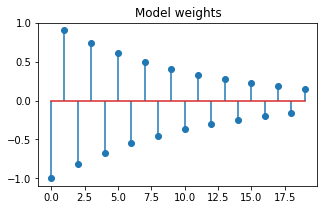

In [3]:
plt.figure(figsize=(5, 3))
plt.stem(w_true, use_line_collection=True)
plt.title("Model weights")

In [4]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(RMSEModel, X, Y, nb_devices_for_the_run)

In [5]:
obj_min_by_N_descent = SGD_Descent(Parameters(n_dimensions = dim_notebook + 1, 
                                                     nb_devices=nb_devices_for_the_run,
                                                     nb_epoch=2000, 
                                                     momentum = 0., 
                                                     verbose=True, 
                                                     cost_models=cost_models,
                                                     stochastic=False,
                                                     bidirectional=False
                                                    ))
obj_min_by_N_descent.run(cost_models)
pickle_saver(obj_min_by_N_descent.losses[-1], filename + "-obj_min")

   it    |   obj   
     400 | 9.6542e-14
     800 | 1.6448e-26
    1200 | 5.1836e-30
    1600 | 5.1836e-30
Gradient Descent: execution time=77.641 seconds
Final loss : 0.00000



In [6]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models, step_formula=deacreasing_step_size,
                                              compression_model = SQuantization(1, dim_notebook+1))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

100%|██████████| 5/5 [3:13:27<00:00, 2321.44s/it]


CPU times: user 1h 12min 28s, sys: 10.3 s, total: 1h 12min 38s
Wall time: 3h 13min 27s


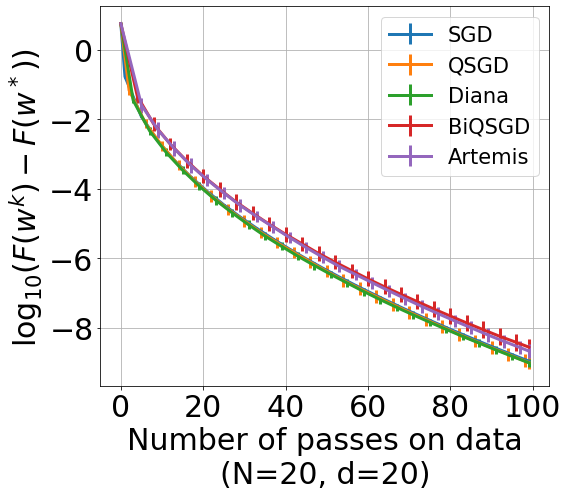

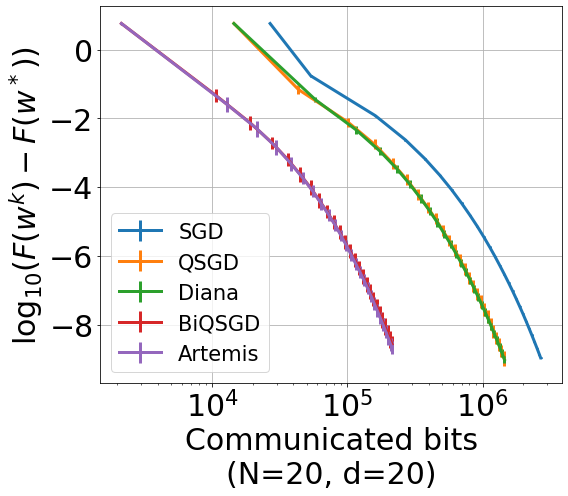

In [7]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj))  


## Devices sampling

In [8]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models, step_formula=deacreasing_step_size,
                                              fraction_sampled_workers=0.5,
                                              compression_model = SQuantization(1, dim_notebook+1))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

100%|██████████| 5/5 [1:33:11<00:00, 1118.21s/it]


CPU times: user 43min 51s, sys: 5.14 s, total: 43min 56s
Wall time: 1h 33min 12s


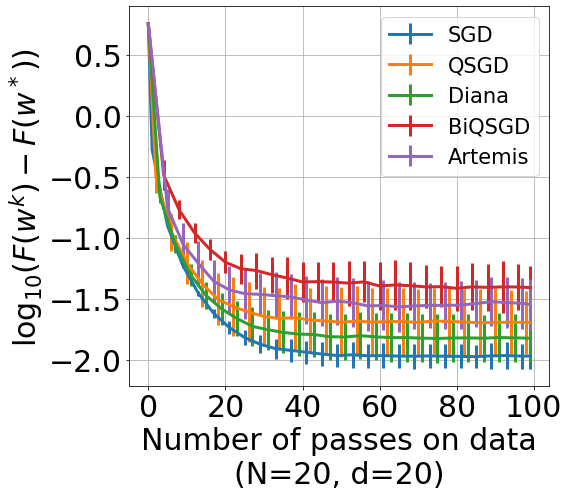

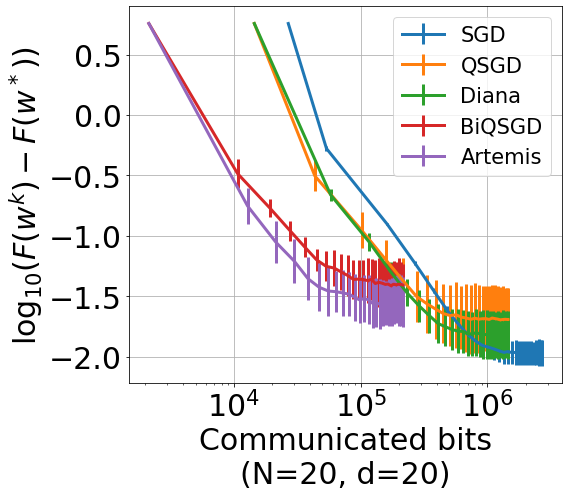

In [9]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj))  
